# Loan Cutomer Behavior

**Source:** Kaggle (https://www.kaggle.com/datasets/subhamjain/loan-prediction-based-on-customer-behavior)
**Author of solution:** Ilan Grynszpan

### Summary:

1. Imports
2. Read and summarize data
3. Data cleaning
4. Exploratory data analysis
5. Modelling

## Imports

In [34]:
import pandas as pd

## visuals
import seaborn as sns
import matplotlib.pyplot as plt

## aux
import os

## Read and summarize data

In [3]:
BASE_DIR = "data"
print(os.listdir(BASE_DIR))
dataframes = [pd.read_csv(os.path.join(BASE_DIR, df)) for df in os.listdir(BASE_DIR)]

['Sample Prediction Dataset.csv', 'Test Data.csv', 'Training Data.csv']


In [7]:
train_data = dataframes[2]
test_data = dataframes[1]

### summarize and test for null values

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [11]:
train_data.isnull().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

In [12]:
train_data.describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


Looks like there is no need for data cleaning

### Exploratory data analysis

Hypothesis 1: People who are between 30 and 60 have the lowest risk of defaulting.

In [13]:
H1 = train_data[['Age', 'Risk_Flag']]

In [32]:
## Dividing age between groups of 10 years

bins = [ten for ten in range(20,90,10)]
age_groups = pd.cut(H1.Age, bins=bins, labels=bins[:-1], right=False)
H1['age_group'] = age_groups
H1

C:\Users\ilang\AppData\Local\Temp/ipykernel_9276/3766892892.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H1['age_group'] = age_groups


,Age,Risk_Flag,age_group
0,23,0,20
1,40,0,40
2,66,0,60
3,41,1,40
4,47,1,40
...,...,...,...
251995,43,0,40
251996,26,0,20
251997,46,0,40
251998,45,0,40


In [33]:
risk_by_age_group = H1[['age_group','Risk_Flag']].groupby('age_group').mean().sort_values('age_group')
risk_by_age_group

,Risk_Flag
age_group,
20,0.146189
30,0.122007
40,0.117194
50,0.120675
60,0.115862
70,0.118044


[]

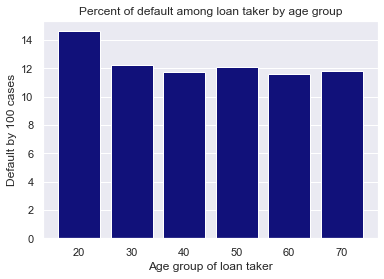

In [40]:
sns.set_theme()

fig = sns.barplot(
    x = risk_by_age_group.index,
    y = 100*(risk_by_age_group.Risk_Flag),
    color = "darkblue"
)

fig.set(xlabel='Age group of loan taker', ylabel='Default by 100 cases', title = "Percent of default among loan taker by age group")
plt.plot()

** Hypothesis 1 is false. The risk is indeed higher in the group between 20 and 30 years old, but is quite similar among the other age groups, being slightly higher among peolle who are between 30 and 40 or between 50 and 60 years old.**